In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
import sys
from pprint import pprint
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

module_path = "../../ad_afqmc"

if module_path not in sys.path:
    sys.path.append(module_path)

from ad_afqmc import (
    driver,
    pyscf_interface,
    mpi_jax,
    linalg_utils,
    spin_utils,
    lattices,
    propagation,
    wavefunctions,
    hamiltonian,
    misc
)

from pyscf import fci, gto, scf, mp, ao2mo
import jax.numpy as jnp

np.set_printoptions(precision=5, suppress=True)

In [5]:
import matplotlib as mpl
import matplotlib.font_manager as font_manager
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import rcParams
import matplotlib.colors as mcolors
plt.rc('font',family='serif')
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('axes',labelsize=20)
plt.rc('axes',titlesize=20)
plt.rc('legend',fontsize=16)
plt.rc('lines', linewidth=2)
plt.rc('savefig', dpi=300)

plt.rcParams['figure.autolayout'] =  True
plt.rcParams["font.family"] = "Serif"
cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['axes.unicode_minus']=False
plt.rcParams['figure.figsize'] = [10, 8]
colors = list(mcolors.TABLEAU_COLORS.values())

In [6]:
U = 12.0
nx = 4
ny = 4
nup = 8
ndown = 8
bc = 'open_x'
verbose = 3

# -----------------------------------------------------------------------------
# Settings.
#lattice = lattices.triangular_grid(nx, ny, boundary_condition=bc)
lattice = lattices.triangular_grid(nx, ny, open_x=True)
n_sites = lattice.n_sites
n_elec = (nup, ndown)
nocc = sum(n_elec)
filling = nocc / (2*n_sites)
if verbose: print(f'\n# Filling factor = {filling}')


# Filling factor = 0.5


In [7]:
# Integrals in the Hilbert space of the site basis.
integrals = {}
integrals["h0"] = 0.0

h1 = -1.0 * lattice.create_adjacency_matrix()
integrals["h1"] = h1

h2 = np.zeros((n_sites, n_sites, n_sites, n_sites))
for i in range(n_sites): h2[i, i, i, i] = U
integrals["h2"] = ao2mo.restore(8, h2, n_sites)

# Diagonalize `h1`

In [8]:
print(h1)
evals_h1, evecs_h1 = np.linalg.eigh(integrals["h1"])

[[-0. -1. -0. -0. -1. -0. -0. -0. -0. -0. -0. -0. -1. -0. -0. -0.]
 [-1. -0. -1. -0. -1. -1. -0. -0. -0. -0. -0. -0. -1. -1. -0. -0.]
 [-0. -1. -0. -1. -0. -1. -1. -0. -0. -0. -0. -0. -0. -1. -1. -0.]
 [-0. -0. -1. -0. -0. -0. -1. -1. -0. -0. -0. -0. -0. -0. -1. -1.]
 [-1. -1. -0. -0. -0. -1. -0. -0. -1. -1. -0. -0. -0. -0. -0. -0.]
 [-0. -1. -1. -0. -1. -0. -1. -0. -0. -1. -1. -0. -0. -0. -0. -0.]
 [-0. -0. -1. -1. -0. -1. -0. -1. -0. -0. -1. -1. -0. -0. -0. -0.]
 [-0. -0. -0. -1. -0. -0. -1. -0. -0. -0. -0. -1. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -1. -0. -0. -0. -0. -1. -0. -0. -1. -0. -0. -0.]
 [-0. -0. -0. -0. -1. -1. -0. -0. -1. -0. -1. -0. -1. -1. -0. -0.]
 [-0. -0. -0. -0. -0. -1. -1. -0. -0. -1. -0. -1. -0. -1. -1. -0.]
 [-0. -0. -0. -0. -0. -0. -1. -1. -0. -0. -1. -0. -0. -0. -1. -1.]
 [-1. -1. -0. -0. -0. -0. -0. -0. -1. -1. -0. -0. -0. -1. -0. -0.]
 [-0. -1. -1. -0. -0. -0. -0. -0. -0. -1. -1. -0. -1. -0. -1. -0.]
 [-0. -0. -1. -1. -0. -0. -0. -0. -0. -0. -1. -1. -0. -1. -0. 

In [9]:
# Make dummy molecule.
mol = gto.Mole()
mol.nelectron = nocc
mol.incore_anyway = True
mol.spin = abs(n_elec[0] - n_elec[1])
mol.verbose = verbose
mol.build()

# Prep AFQMC.
umf = scf.UHF(mol)
umf.get_hcore = lambda *args: integrals["h1"]
umf.get_ovlp = lambda *args: np.eye(n_sites)
umf._eri = ao2mo.restore(8, integrals["h2"] * 1.0, n_sites)
umf.mo_coeff = np.array([evecs_h1, evecs_h1])
umf.mo_coeff[1][:, ndown-1] = evecs_h1[:, ndown].copy()
umf.mo_coeff[1][:, ndown] = evecs_h1[:, ndown-1].copy()
mo_occa = np.zeros(n_sites, dtype=int)
mo_occb = np.zeros(n_sites, dtype=int)
mo_occa[:nup] = 1
mo_occb[:ndown] = 1
umf.mo_occ = [mo_occa, mo_occb]

# `h1` eigenstates

/local/ipykernel_231525/1223131558.py:7: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots()


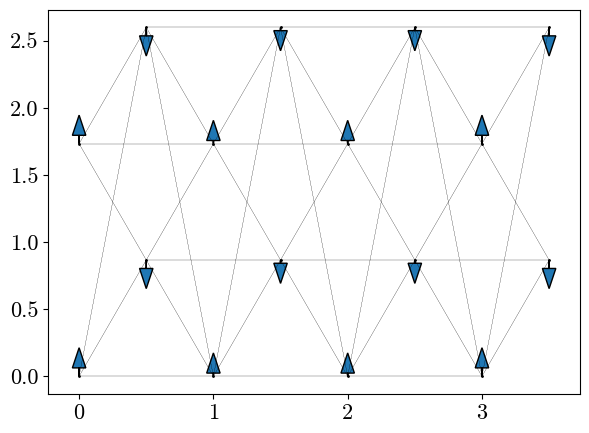

In [12]:
spin_rdm1 = umf.make_rdm1()
sz = (spin_rdm1[0] - spin_rdm1[1]).diagonal() / 2
charge = (spin_rdm1[0] + spin_rdm1[1]).diagonal()
sx = np.zeros_like(sz)

# draw the triangular lattice with arrows showing the spin
fig, ax = plt.subplots()
fig.set_size_inches(6, 6)
coords = np.array([lattice.get_site_coordinate(site) for site in lattice.sites])
arrow_size = 0.7
for i in range(n_sites):
    site = coords[i]
    x, y = site
    ax.plot(x, y, "ko", markersize=1)
    ax.arrow(
        x,
        y,
        arrow_size * sx.ravel()[i],
        arrow_size * sz.ravel()[i],
        head_width=0.1,
    )
    # draw lines to nearest neighbors
    nn = np.nonzero(lattice.create_adjacency_matrix()[i])[0]
    for n in nn:
        site_n = coords[n]
        x_n, y_n = site_n
        ax.plot(
            [x, x_n],
            [y, y_n],
            "k-",
            lw=0.1,
        )
ax.set_aspect("equal")

/local/ipykernel_231525/780053125.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(1, 1, figsize=(6, 4))


Text(0, 0.5, '$E$ (Ha)')

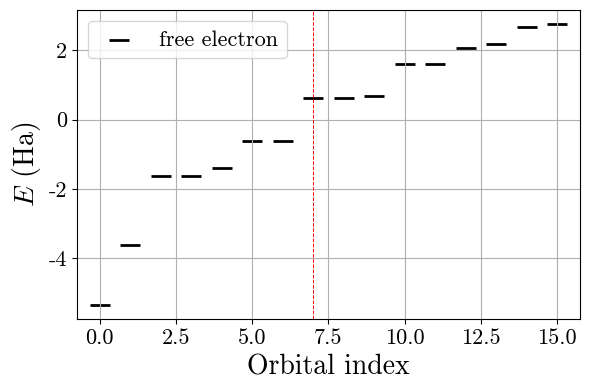

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.scatter(np.arange(evals_h1.shape[0]), evals_h1, marker='_', s=200, c='k', label='free electron')
ax.axvline(len(evals_h1) // 2 - 1, ls='--', lw=0.7, color='r')

ax.grid()
ax.legend()
ax.set_xlabel('Orbital index')
ax.set_ylabel('$E$ (Ha)')

In [15]:
sha1, branch, local_mods = misc.get_git_info()
sys_info = misc.print_env_info(sha1, branch, local_mods)

# ad_afqmc version: Unknown
# Git hash: 9b7c527a64c5e27ff50321631a0f70753f1f2f87.
# Git branch: hubbard.
# Found uncommitted changes and/or untracked files.
# Untracked : ad_afqmc/driver_v2.py
# Untracked : ad_afqmc/mpi_jax_v2.py
# Untracked : ad_afqmc/propagation_v2.py
# Untracked : ad_afqmc/sampling_v2.py
# Untracked : ad_afqmc/wavefunctions_v2.py
# Approximate memory available per node: 754.5479 GB.
# Root processor name: g140
# Python interpreter: 3.9.20 (main, Oct  3 2024, 07:27:41)  [GCC 11.2.0]
# Using numpy v1.24.3 from: /burg/ccce/users/su2254/envs/ad_afqmc/lib/python3.9/site-packages/numpy.
# - BLAS lib: mkl_rt pthread
# - BLAS dir: /burg/ccce/users/su2254/envs/ad_afqmc/lib
# Using scipy v1.7.1 from: /burg/ccce/users/su2254/envs/ad_afqmc/lib/python3.9/site-packages/scipy.
# Using h5py v3.13.0 from: /burg/ccce/users/su2254/envs/ad_afqmc/lib/python3.9/site-packages/h5py.
# Using mpi4py v3.1.4 from: /burg/ccce/users/su2254/envs/ad_afqmc/lib/python3.9/site-packages/mpi4py.
# - mp

In [20]:
# AFQMC.
run_cpmc = True
nwalkers = 50
pyscf_interface.prep_afqmc(umf, basis_coeff=np.eye(n_sites), integrals=integrals)

options = {
    "dt": 0.005,
    "n_eql": 1,
    "n_ene_blocks_eql": 1,
    "n_sr_blocks_eql": 1,
    "n_ene_blocks": 1,
    "n_sr_blocks": 5,
    "n_blocks": 2,
    "n_prop_steps": 50,
    "n_walkers": nwalkers,
    "seed": 98,
    "walker_type": "uhf",
    "trial": "uhf",
    "save_walkers": False,
    "ad_mode": "mixed", # Needed for RDM1.
}

ham_data, ham, prop, trial, wave_data, sampler, observable, options, MPI = (
    mpi_jax._prep_afqmc(options)
)

#
# Preparing AFQMC calculation
# Calculating Cholesky integrals
# Finished calculating Cholesky integrals
#
# Size of the correlation space:
# Number of electrons: (8, 8)
# Number of basis functions: 16
# Number of Cholesky vectors: 16
#
# Number of MPI ranks: 1
#
# norb: 16
# nelec: (8, 8)
#
# dt: 0.005
# n_eql: 1
# n_ene_blocks_eql: 1
# n_sr_blocks_eql: 1
# n_ene_blocks: 1
# n_sr_blocks: 5
# n_blocks: 2
# n_prop_steps: 50
# n_walkers: 50
# seed: 98
# walker_type: uhf
# trial: uhf
# save_walkers: False
# ad_mode: mixed
# orbital_rotation: True
# do_sr: True
# symmetry: False
# ene0: 0.0
# free_projection: False
# n_batch: 1
# vhs_mixed_precision: False
# trial_mixed_precision: False
# memory_mode: low
#


In [21]:
if run_cpmc:
    if verbose: print(f'\n# Using CPMC propagator...')
    prop = propagation.propagator_cpmc_slow(
        dt=options["dt"],
        n_walkers=options["n_walkers"],
    )
trial = wavefunctions.uhf_cpmc(n_sites, n_elec)
wave_data["mo_coeff"] = [umf.mo_coeff[0, :, :n_elec[0]], 
                         umf.mo_coeff[1, :, :n_elec[1]]]

# wave_data["rdm1"] = spin_rdm1

# trial_1 = wavefunctions.uhf_cpmc(n_sites, n_elec)
# trial_2 = wavefunctions.uhf_cpmc(n_sites, n_elec)
# trial = wavefunctions.sum_state(n_sites, n_elec, (trial_1, trial_2))

# wave_data_0 = wave_data.copy()q
# wave_data_0["mo_coeff"] = [
#     umf.mo_coeff[0][:, : n_elec[0]],
#     umf.mo_coeff[1][:, : n_elec[1]],
# ]
# wave_data_1 = wave_data.copy()
# wave_data_1["mo_coeff"] = [
#     umf.mo_coeff[1][:, : n_elec[0]],
#     umf.mo_coeff[0][:, : n_elec[1]],
# ]
# wave_data["coeffs"] = jnp.array([1 / 2**0.5, 1 / 2**0.5]) 
# wave_data["0"] = wave_data_0
# wave_data["1"] = wave_data_1

ham_data["u"] = U

e_afqmc, err_afqmc = driver.afqmc(
    ham_data, ham, prop, trial, wave_data, sampler, observable, options, MPI
)


# Using CPMC propagator...
# ad_afqmc version: Unknown
# Git hash: 9b7c527a64c5e27ff50321631a0f70753f1f2f87.
# Git branch: hubbard.
# Found uncommitted changes and/or untracked files.
# Untracked : ad_afqmc/driver_v2.py
# Untracked : ad_afqmc/mpi_jax_v2.py
# Untracked : ad_afqmc/propagation_v2.py
# Untracked : ad_afqmc/sampling_v2.py
# Untracked : ad_afqmc/wavefunctions_v2.py
# Approximate memory available per node: 754.5479 GB.
# Root processor name: g140
# Python interpreter: 3.9.20 (main, Oct  3 2024, 07:27:41)  [GCC 11.2.0]
# Using numpy v1.24.3 from: /burg/ccce/users/su2254/envs/ad_afqmc/lib/python3.9/site-packages/numpy.
# - BLAS lib: mkl_rt pthread
# - BLAS dir: /burg/ccce/users/su2254/envs/ad_afqmc/lib
# Using scipy v1.7.1 from: /burg/ccce/users/su2254/envs/ad_afqmc/lib/python3.9/site-packages/scipy.
# Using h5py v3.13.0 from: /burg/ccce/users/su2254/envs/ad_afqmc/lib/python3.9/site-packages/h5py.
# Using mpi4py v3.1.4 from: /burg/ccce/users/su2254/envs/ad_afqmc/lib/python3.9/

In [22]:
npz = np.load('rdm1_afqmc.npz')
list(npz)

['rdm1_avg', 'rdm1_err', 'rdm1_noise', 'rdm1_noise_err']

In [23]:
rdm1 = npz['rdm1_avg']
rdm1a, rdm1b = rdm1

In [24]:
density_a = np.diag(rdm1a)
density_b = np.diag(rdm1b)

/local/ipykernel_231525/297459799.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, axs = plt.subplots(1, 4, figsize=(12, 8))
/local/ipykernel_231525/297459799.py:24: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cax = divider.append_axes('right', size='5%', pad=0.05)
/local/ipykernel_231525/297459799.py:25: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig.colorbar(im, cax=cax, orientation='vertical')


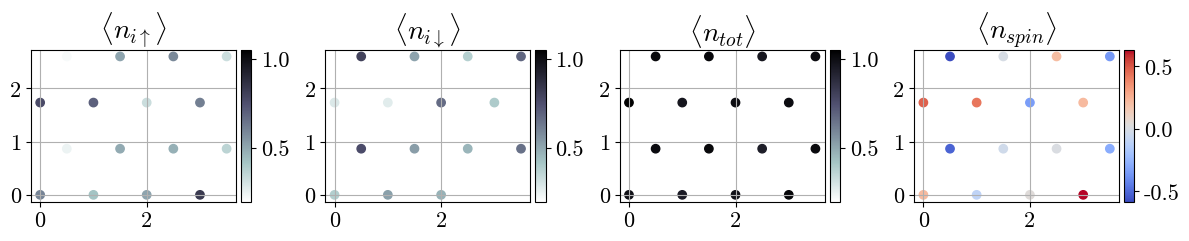

In [25]:
fig, axs = plt.subplots(1, 4, figsize=(12, 8))

dat = [density_a, density_b, density_a + density_b, density_a - density_b]

vmin_tot = np.amin(dat[:-1])
vmax_tot = np.amax(dat[:-1])
vmin_spin = np.amin(dat[-1])
vmax_spin = np.amax(dat[-1])

titles = [r'$\langle n_{i \uparrow} \rangle$', r'$\langle n_{i \downarrow} \rangle$', r'$\langle n_{tot} \rangle$', r'$\langle n_{spin} \rangle$']

for i, ax in enumerate(axs):
    z = dat[i]

    if i < 3: 
        cmap = 'bone_r'
        im = ax.scatter(coords[:, 0], coords[:, 1], c=z, cmap=cmap, vmin=vmin_tot, vmax=vmax_tot)
        
    else: 
        cmap = 'coolwarm'
        im = ax.scatter(coords[:, 0], coords[:, 1], c=z, cmap=cmap, vmin=vmin_spin, vmax=vmax_spin)
        
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    
    ax.grid()
    ax.set_title(titles[i])
    ax.set_aspect("equal")

plt.tight_layout()